# Final Project: Apple Disease Classification
**Based on the Kaggle competition: [Apple Disease Classification](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)**

### Setting up Env

In [3]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers
   ! pip install -q transformers[torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Running in local environment...")

Running in local environment...


In [4]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Sucesfully set kaggle credentials


### Downloading the data

In [53]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('plant-pathology-2020-fgvc7')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data not detected, starting download
plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)
images	sample_submission.csv  test.csv  train.csv


In [52]:
#Images are initially all stored in a single folder, for easier compatability with fastAI dataloaders we will split the test and train images into 2 different folders

#Not needed any longer 

"""
import os
import shutil

# Create a new folder called test unless it already exists
if not os.path.exists('test'):
    os.mkdir('plant-pathology-2020-fgvc7/test')
    os.mkdir('plant-pathology-2020-fgvc7/train')
 
# Move all images from the images folder starting with Test_ to a new subfolder called test within plant-pathology-2020-fgvc7
for file_name in os.listdir('plant-pathology-2020-fgvc7/images'):
    if file_name.startswith('Test_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/test')
    elif file_name.startswith('Train_'):
        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/train')
        
        

"""

"\nimport os\nimport shutil\n\n# Create a new folder called test unless it already exists\nif not os.path.exists('test'):\n    os.mkdir('plant-pathology-2020-fgvc7/test')\n    os.mkdir('plant-pathology-2020-fgvc7/train')\n \n# Move all images from the images folder starting with Test_ to a new subfolder called test within plant-pathology-2020-fgvc7\nfor file_name in os.listdir('plant-pathology-2020-fgvc7/images'):\n    if file_name.startswith('Test_'):\n        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/test')\n    elif file_name.startswith('Train_'):\n        shutil.move(f'{path}/images/{file_name}', 'plant-pathology-2020-fgvc7/train')\n        \n        \n\n"

In [54]:
import timm
from fastai.vision.all import *

image_path = path/'images'
image_files = get_image_files(image_path)

"""
train_path = path/'train'
train_files = get_image_files(train_path)

test_path = path/'test'
test_files = get_image_files(train_path)

"""

"\ntrain_path = path/'train'\ntrain_files = get_image_files(train_path)\n\ntest_path = path/'test'\ntest_files = get_image_files(train_path)\n\n"

In [61]:
#Simply contains the filename of all the images in the given folder
image_files[0:3]

(#3) [Path('plant-pathology-2020-fgvc7/images/Train_719.jpg'),Path('plant-pathology-2020-fgvc7/images/Test_717.jpg'),Path('plant-pathology-2020-fgvc7/images/Train_544.jpg')]

Shape of image : (1365, 2048)


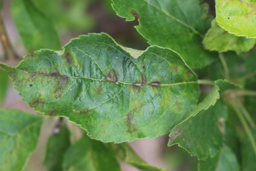

In [62]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

### Inspecting the image sizes


In [63]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

sizes = parallel(check_size, image_files, n_workers=n_cores)
pd.Series(sizes).value_counts()

Number of cores 16


(1365, 2048)    3642
Name: count, dtype: int64

In [31]:
#sizes = parallel(check_size, test_files, n_workers=n_cores)
#pd.Series(sizes).value_counts()

(1365, 2048)    1819
(2048, 1365)       2
Name: count, dtype: int64

The images are of similar size, but a few are rotated. To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.

In [64]:
#Function to load images, and if they are in the wrong orientation, rotate them and overwrite 

#NOTE Should correct so that it doesn't flip the Test Images as well :-)

def check_transpose(img):
    img_loaded = PILImage.create(img)
    if img_loaded.shape == (2048,1365):
        print('Flipped image: ', img_loaded)
        #Transpose the image 90 degrees and overwrite the original image
        img_rotated = img_loaded.rotate(90, expand=True)
        #img_rotated.show()
        #Save the image
        img_rotated.save(img)
        return img_rotated.shape
    else:
        return img_loaded.shape

image_sizes = parallel(check_transpose, image_files, n_workers=n_cores)
print(f'Images size after rotation: {pd.Series(sizes).value_counts()}')

#test_sizes = parallel(check_transpose, test_files, n_workers=n_cores)
#print(f'Test images size after rotation: {pd.Series(sizes).value_counts()}')

Images size after rotation: (1365, 2048)    3642
Name: count, dtype: int64


### Inspecting the labels and reformating

In [65]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df = pd.read_csv(f'{path}/train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [66]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df['label'] = df.apply(lambda col: df.columns[2:5][np.argmax(col.values[2:5])], axis=1)
df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,multiple_diseases
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,multiple_diseases


In [69]:
path

Path('plant-pathology-2020-fgvc7')

In [70]:
#Add the full path as suffix to the image_id as stored in path plus a "/" in between
